<a href="https://colab.research.google.com/github/worldone-web/Team4-Traveler/blob/main/BPR_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#Git에 있는 평가함수

import numpy as np
import torch


def hit(gt_item, pred_items):
	if gt_item in pred_items:
		return 1
	return 0


def ndcg(gt_item, pred_items):
	if gt_item in pred_items:
		index = pred_items.index(gt_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k):
	HR, NDCG = [], []

	for user, item_i, item_j in test_loader:
		user = user.cuda()
		item_i = item_i.cuda()
		item_j = item_j.cuda() # not useful when testing

		prediction_i, prediction_j = model(user, item_i, item_j)
		_, indices = torch.topk(prediction_i, top_k)
		recommends = torch.take(
				item_i, indices).cpu().numpy().tolist()

		gt_item = item_i[0].item()
		HR.append(hit(gt_item, recommends))
		NDCG.append(ndcg(gt_item, recommends))

	return np.mean(HR), np.mean(NDCG)

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/BPR/philadelphia_rating_BPR.csv")
df

,newUserId,newBusinessId
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
332974,11668,7007
332975,11914,7008
332976,11941,7009
332977,11978,7010


In [ ]:
# 사용자 수 출력
num_users = df["newUserId"].nunique()
print("사용자 수:", num_users)

# 음식점 수 출력
num_businesses = df["newBusinessId"].nunique()
print("음식점 수:", num_businesses)

사용자 수: 12062
음식점 수: 7011


In [ ]:
import pandas as pd

# 각 사용자별로 n번째 음식점 방문기록 까지 데이터를 테스트 데이터로, 나머지를 트레이닝 데이터로 분리하는 함수
def split_train_test_data(df, n=3, user_col='newUserId', item_col='newBusinessId', output_dir='.'):
    train_data = []
    test_data = []

    # 사용자별로 그룹화하여 처리
    for user_id, group in df.groupby(user_col):
        # 첫 번째부터 n번째 음식점 방문 기록을 test_data로 추가
        test_data.extend(group.iloc[:n].values.tolist())

        # n+1번째부터 마지막 음식점 방문 기록을 train_data로 추가
        train_data.extend(group.iloc[n:].values.tolist())

    train_df = pd.DataFrame(train_data, columns=[user_col, item_col])
    test_df = pd.DataFrame(test_data, columns=[user_col, item_col])


    train_size = train_df.shape
    test_size = test_df.shape
    print("Train 데이터 크기:", train_size)
    print("Test 데이터 크기:", test_size)
    print("Test 데이터 크기 / Train 데이터 크기 비율:", test_size[0] / train_size[0]) # 전체 크기의 대략 10%

    # CSV 파일로 저장
    train_df.to_csv(f"{output_dir}/train.csv", index=False, header=False, sep='\t')
    test_df.to_csv(f"{output_dir}/test.csv", index=False, header=False, sep='\t')

    print("'train.csv'와 'test.csv' 파일이 생성되었습니다.")

split_train_test_data(df, n=3, output_dir="/content/drive/MyDrive/BPR")


Train 데이터 크기: (296794, 2)
Test 데이터 크기: (36185, 2)
Test 데이터 크기 / Train 데이터 크기 비율: 0.12191958058451316
'train.csv'와 'test.csv' 파일이 생성되었습니다.


In [ ]:
import pandas as pd
import numpy as np
import random

# 각 사용자별로 부정적인 조합 생성
def generate_negative_samples(df, n=100, user_col='newUserId', item_col='newBusinessId', output_dir='.'):
    # 사용자와 음식점 집합 구하기
    users = df[user_col].unique()
    businesses = df[item_col].unique()

    # 사용자별로 부정적인 조합 저장
    user_negative_samples = {}

    # 각 사용자에 대해 부정적인 조합 생성
    for user in users:
        # 사용자가 방문한 음식점 집합
        user_visited_businesses = set(df[df[user_col] == user][item_col].unique())

        # 사용자가 방문하지 않은 음식점 찾기
        user_not_visited_businesses = list(set(businesses) - user_visited_businesses)

        # 랜덤 샘플링하여 부정적인 조합 생성
        if len(user_not_visited_businesses) > n: #n개 이상이면 데이터가 많아지니 제한을 둠
            user_negative_samples[user] = random.sample(user_not_visited_businesses, n)
        else:
            user_negative_samples[user] = user_not_visited_businesses

    # 부정적인 조합을 CSV 파일로 저장
    with open(f"{output_dir}/negative.csv", 'w') as f:
        for user, negatives in user_negative_samples.items():
            f.write(f"{user},{','.join(map(str, negatives))}\n")

    print("파일 'negative.csv'가 생성되었습니다.")

generate_negative_samples(df, n=100, output_dir="/content/drive/MyDrive/BPR")


파일 'negative.csv'가 생성되었습니다.


In [ ]:
#BPR2 에 있는 부정적인 조합만들기3
import pandas as pd
import random

# 개인별로 방문하지 않은 음식점 샘플링
def generate_individual_negative_sample(df, user_id, n=100, user_col='newUserId', item_col='newBusinessId'):
    # 모든 음식점 목록 가져오기
    businesses = df[item_col].unique()
    # 사용자가 방문한 음식점 목록 가져오기
    user_visited_businesses = set(df[df[user_col] == user_id][item_col].unique())
    # 사용자가 방문하지 않은 음식점 목록 계산
    user_not_visited_businesses = list(set(businesses) - user_visited_businesses)
    # 방문하지 않은 음식점 중에서 n개를 랜덤으로 샘플링
    if len(user_not_visited_businesses) > n:
        random_negative = random.sample(user_not_visited_businesses, n)
    else:
        random_negative = user_not_visited_businesses
    return random_negative

# 파일 경로 설정
path = "/content/drive/MyDrive/BPR/"

# testData를 위한 부정적인 음식점 샘플링
with open(path + 'negative.csv', 'r') as negative_file, open(path + 'test.csv', 'r') as test_file, open(path + 'test_negative.csv', 'w') as test_negative_file:
    read_negative = negative_file.readlines()
    read_test = test_file.readlines()
    print(len(read_negative))  # 12062 -> 사용자 수만큼 개인별로 방문하지 않은 음식점 집합 완성

    for i in range(len(read_negative)):  # 각 사용자에 대해
        negative = read_negative[i]  # 사용자 i에 대한 방문하지 않은 음식점 집합 가져오기
        user_id, user_id_negative_businesses = negative.strip().split(',', 1)  # 사용자 ID와 방문하지 않은 음식점 구분
        #user_id_negative_businesses = user_id_negative_businesses.split(',')  # 방문하지 않은 음식점들을 리스트로 분리

        for j in range(i * 3, (i + 1) * 3):  # 각 사용자의 3개의 음식점 방문기록
            test = read_test[j % len(read_test)]  # 테스트 데이터 중 해당 사용자의 음식점 방문기록
            user_trip = test.strip()  # 공백 제거

            # 개별 사용자의 부정적인 음식점 생성
            individual_negative_sample = generate_individual_negative_sample(df, int(user_id), n=100)

            # 테스트 데이터와 부정적인 샘플을 결합하여 git에 있는 BPR모델 입력에 맞게 변환
            test_negative_business = user_trip + '\t' + '\t'.join(map(str, individual_negative_sample)) + '\n'
            test_negative_file.write(test_negative_business)

print("파일 'test_negative.csv'가 생성되었습니다.")




12062
파일 'test_negative.csv'가 생성되었습니다.


In [ ]:
#경로지정

dataset = 'philadelphia_rating_BPR'
assert dataset in ['philadelphia_rating_BPR']

# paths
main_path = '/content/drive/MyDrive/BPR/'

train_rating = main_path + 'train.csv'.format(dataset)
test_rating = main_path + 'test.csv'.format(dataset)
test_negative = main_path + 'negative.csv'.format(dataset)


BPR(Bayesian Personalized Ranking) 코드에서 사전 확률(prior probability)과 가능도(likelihood)는 명시적으로 다루어지지 않는다. BPR은 사용자-아이템 상호작용 데이터를 바탕으로 쌍별 순위(pairwise ranking)를 학습하는 방법으로, 기본적인 베이지안 모델링 접근 방식과는 다소 차이가 있다. 그러나 BPR 모델의 핵심 아이디어는 여전히 베이지안 원리에 기반하고 있다.

---

 Bayesian optimization이란, 사후 확률을 최대화 하는 파라미터 Θ를 찾는 것이다.

 사후확률을 p(Θ | >u)로 표현할 수 있다.

 사후확률이란 '어떤 정보'가 고려된 파라미터 Θ에 대한 확률이다.
 여기서 '어떤 정보'란 user의 선호정보(>u)이다.

 여기서 user의 선호정보(>u)는 아직 알지 못하기 때문에 이와 비례하는 사전확률과 가능도의 곱을 사용하여 학습한다.

 이는 베이즈 정리(Bayes' Theorem)에 근거하여
 p(Θ | >u) ∝p( >u |Θ)p(Θ)로 식을 표현할 수 있다.

 p( >u |Θ)p(Θ) 해당식은 가능도(likelihood)와 사전확률의 곱을 의미하는 식이다.

먼저 가능도(likelihood) = p( >u |Θ)식에 대해서 살펴보자. 식은 다음과 같이 전개된다.
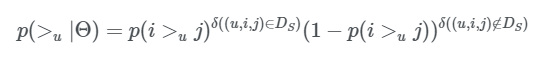

해당식에서 p(i >u j)가 있는데 이는 user가 j보다 i를 선호할 확률이다. 우리는 해당값을 계산하여 likelihood 값을 구해야한다.

user j보다 i를 선호할 확률의 기호를 x(uij)라고 정의한다.

x(uij)의 값을 sigmoid함수를 이용하여 user가 아이템 j보다 i를 선호할 확률을 다음과 같이 구할 수 있다.

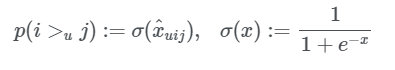

그러면 x(uij)의 값 자체를 구해야하는데 이는 Matrix Factorization에 답이 존재한다. 우리는 Matrix Fatorziation에서 유저와 아이템 행렬을 각각 잠재적인 요소 k를 가지는 행렬로 만들어서 다시 내적한 값을 이용하여 예측점수 값을 획득했다.
이방식을 그대로 사용하여 x(uij)값을 구해보자.

우리는 user, item i, item j가 존재하므로 총 3개의 latent vector을 만들어야 한다.

여기서 잠깐 2가지 정의를  살펴보고 넘어가보겠습니다.

(1) Θ = {P(u), Q(i)} (여기서 P(u), Q(i)는 각각 user, item latent vector)

(2)x(uij) = x(ui) - x(uj) = P(u)(Q(i)^T) - P(u)*(Q(j)^T)

먼저 MF는 user와 item의 latent vextor를 예측하는 것이므로, P(u), Q(i)가 파라미터가 된다.

user와 item i, item j 간의 관계인 x(uij)는
user의 item i에 대한 점수인 x(ui)와, item j에 대한 점수인 x(uj)의 차이로 정의된다.

이 차이가 양수이면서 클수록 위의 정의된 sigmoid 함수에 넣었을 경우 1에 가까워 진다.



이를 바탕으로 한 optimization function은 다음과 같다.

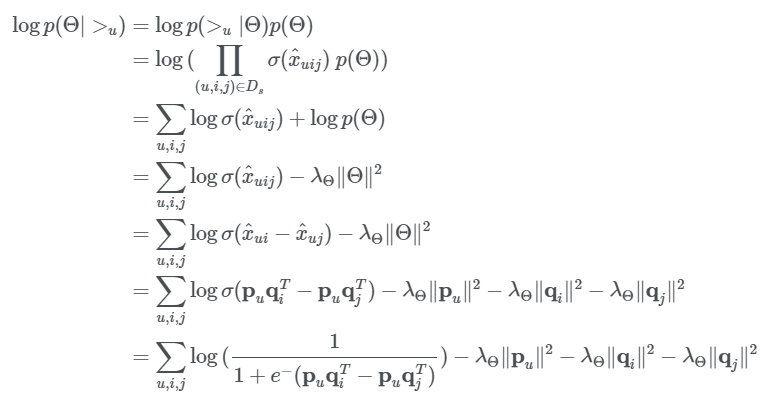



BPR의 주요 목표는 주어진 사용자에 대해 선호하는 아이템이 덜 선호하는 아이템보다 더 높은 순위에 오도록 학습한다.

이를 위해, BPR은 다음과 같은 손실 함수를 사용한다.

loss=−∑
(u,i,j)∈D
ln σ(
x
  ui
 −
x
  uj
 )

여기서
𝜎
는 시그모이드 함수이다.

ln은 자연로그를 의미한다. 원래는 곱연산을 통해 값을 구해야하는데 그러면 값이 너무 작은 경우 언더플로우가 발생하므로 합연산을 통해 수치석 안정성을 제공한다.

이 함수는 사용자
𝑢
가 아이템
𝑖
를 아이템
𝑗
보다 더 선호할 확률을 최대화한다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import os
import time
import numpy as np
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import random
import torch.utils.data as data

# 하드코딩된 기본값 설정
lr = 0.01
lamda = 0.001
batch_size = 4096
epochs = 10
top_k = 10
num_factors = 32
num_ng = 4
test_num_ng = 99
out = True

def load_all():
    # 학습 데이터 로드
    train_data = pd.read_csv(
        train_rating,
        sep='\t', header=None, names=['user', 'item'],
        usecols=[0, 1], dtype={0: np.int32, 1: np.int32})


    # 사용자 및 아이템 수 계산
    user_num = train_data['user'].max() + 1
    item_num = train_data['item'].max() + 1

    # 학습 데이터를 리스트로 변환
    train_data = train_data.values.tolist()

    # 학습 데이터를 scipy sparse matrix로 변환
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32) # 희소 행렬은 메모리 사용량을 줄이고, 특정 요소에 대한 빠른 조회를 가능하게 함.
    for x in train_data: #후속 단계에서 부정적 샘플링을 수행할 때 유용
        train_mat[x[0], x[1]] = 1.0 # 사용자와 음식점의 쌍이 존재한다는것을 알리기 위해 1.0 표시

    # 테스트 데이터 로드
    test_data = []
    with open(test_negative, 'r') as fd:
        line = fd.readline()
        while line != None and line != '':
            arr = line.split('\t') # test_negative를 \t를 기준 형식에 맞추기
            u = eval(arr[0])[0] # 사용자 n
            test_data.append([u, eval(arr[0])[1]]) #방문한 음식점 추가
            for i in arr[1:]:
                test_data.append([u, int(i)]) #방문하지 않은 음식점 추가
            line = fd.readline()


    return train_data, test_data, user_num, item_num, train_mat


class BPRData(data.Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(BPRData, self).__init__()
        self.features = features # train_data
        self.num_item = num_item # 아이템 수
        self.train_mat = train_mat # 훈련 데이터의 희소 행렬
        self.num_ng = num_ng # 부정적 샘플의 수
        self.is_training = is_training # 훈련모드의 여부

    def ng_sample(self): # 부정적 샘플링
        assert self.is_training, 'no need to sampling when testing'

        self.features_fill = []
        for x in self.features:
            u, i = x[0], x[1]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat: #train_mat를 사용하여 (u,j)라는 특정 사용자-아이템 쌍이 train_data에 존재하는지 여부를 빠르게 확인함.
                    j = np.random.randint(self.num_item) # (u,j)가 희소행렬에 존재 한다면 방문하지 않은 음식점 j를 찾을 때까지 랜덤값으로 값 획득
                self.features_fill.append([u, i, j]) #triple_data를 획득

    def __len__(self):
        if self.is_training:
            return self.num_ng * len(self.features)
        else:
            return len(self.features)

    def __getitem__(self, idx):
        features = self.features_fill if self.is_training else self.features

        user = features[idx][0]
        item_i = features[idx][1]
        item_j = features[idx][2] if self.is_training else features[idx][1]
        return user, item_i, item_j


class BPR(nn.Module):
    def __init__(self, num_users, num_items, num_factors=10):
        super(BPR, self).__init__()
        self.user_factors = nn.Embedding(num_users, num_factors) # 초기 임베딩값을 무작위로 넣는게 사전확률로 볼 수 있다.
        self.item_factors = nn.Embedding(num_items, num_factors)

    def forward(self, user_ids, item_ids_i, item_ids_j):
      user_embedding = self.user_factors(user_ids) # # 파라미터 p(u)
      item_embedding_i = self.item_factors(item_ids_i) #파라미터 q(i)
      item_embedding_j = self.item_factors(item_ids_j)# 파라미터 q(j)

      # 내적을 통한 예측값 계산

      #x(uij)를 구하기 위한과정
      pred_i = torch.sum(user_embedding * item_embedding_i, dim=-1)  #아이템 i에 대한 점수 x(ui) -> p(u)*(q(i)^T)
      pred_j = torch.sum(user_embedding * item_embedding_j, dim=-1) #아이템 j에 대한 점수 x(uj)  -> p(u)*(q(j)^T)

      return pred_i, pred_j

################# DATASET 준비 ##################
train_data, test_data, user_num ,item_num, train_mat = load_all()

train_dataset = BPRData(
		train_data, item_num, train_mat, num_ng, True)
test_dataset = BPRData(
		test_data, item_num, train_mat, 0, False)

train_loader = data.DataLoader(train_dataset,
		batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset,
		batch_size=test_num_ng+1, shuffle=False, num_workers=0)


################# 모델 생성 ##################
model = BPR(user_num, item_num, num_factors)
model.cuda()

optimizer = optim.SGD(
            model.parameters(), lr=lr, weight_decay=lamda)


########################### 훈련 #####################################
count, best_hr = 0, 0
for epoch in range(epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for user, item_i, item_j in train_loader:
        user = user.cuda()
        item_i = item_i.cuda()
        item_j = item_j.cuda()

        model.zero_grad()
        prediction_i, prediction_j = model(user, item_i, item_j)

        #(prediction_i - prediction_j): user의 item_i 와 item_j의 점수차이 계싼 -> x(uij) = 이 차이가 크고 양수일수록 sigmoid에 넣었을 때 1에 가까워짐
        # sigmoid(): 시그모이드 함수를 적용하여 확률 값으로 변환
        # log -likelihood와 유사한 역할 - 수식을 곱셈에서 덧셈으로 변하게 하여 언더플로우를 방지
        # sum(): 전체 손실을 합산

        # 순전파
        loss = - (prediction_i - prediction_j).sigmoid().log().sum()

        # 역전파
        loss.backward() #손실 함수(loss)의 값을 기준으로 모델의 파라미터에 대한 그래디언트(기울기)를 계산
        # 그래디언트는 모델 파라미터가 현재 값에서 손실을 줄이기 위해 어느 방향으로 얼마나 이동해야 하는지를 결정

        #파라미터 업데이트
        optimizer.step() #앞서 계산된 그래디언트를 사용하여 모델의 파라미터를 업데이트
        #다음 순전파 시 더 나은 예측을 할 수 있도록 도와줌

        # writer.add_scalar('data/loss', loss.item(), count)
        count += 1

    model.eval()
    HR, NDCG = metrics(model, test_loader, top_k)

    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
        time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

    # if HR > best_hr:
    #   best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
    #   if out:
    #     if not os.path.exists(model_path):
    #       os.mkdir(model_path)
    #     torch.save(model, '{}BPR.pt'.format(model_path))

      # print("End. Best epoch {:03d}: HR = {:.3f}, \
      #   NDCG = {:.3f}".format(best_epoch, best_hr, best_ndcg))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


The time elapse of epoch 000 is: 00: 00: 06
HR: 0.091	NDCG: 0.043
The time elapse of epoch 001 is: 00: 00: 06
HR: 0.116	NDCG: 0.053
The time elapse of epoch 002 is: 00: 00: 06
HR: 0.132	NDCG: 0.053
The time elapse of epoch 003 is: 00: 00: 06
HR: 0.132	NDCG: 0.057
The time elapse of epoch 004 is: 00: 00: 06
HR: 0.124	NDCG: 0.053
The time elapse of epoch 005 is: 00: 00: 06
HR: 0.132	NDCG: 0.057
The time elapse of epoch 006 is: 00: 00: 06
HR: 0.124	NDCG: 0.054
The time elapse of epoch 007 is: 00: 00: 07
HR: 0.124	NDCG: 0.056
The time elapse of epoch 008 is: 00: 00: 06
HR: 0.116	NDCG: 0.057
The time elapse of epoch 009 is: 00: 00: 06
HR: 0.124	NDCG: 0.060
